In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt 
%matplotlib inline

import math
from scipy import stats

from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore') 

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import confusion_matrix


In [3]:
asos_df = pd.read_csv('asos_reviews_clean_date.csv')

In [4]:
plt_df = pd.read_csv('plt_reviews_clean_date.csv')

In [5]:
zahul_df = pd.read_csv('zaful_reviews_clean_date.csv')

In [6]:
reviews_df = pd.concat([asos_df, plt_df, zahul_df], axis = 0)

In [7]:
reviews_df

,Unnamed: 0,date,review,stars,length,polarity_before_clean,lower,no_punc,no_stop,no_num,words_removed,token,pos_tags,lemmatized,joined,polarity_after_clean
0,0,2020-12-09,Cristy was amazing ...,5,225,0.580208,cristy was amazing i spoke with cristy and she...,cristy was amazing i spoke with cristy and she...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,cristy amazing spoke cristy brilliant although...,"['cristy', 'amazing', 'spoke', 'cristy', 'bril...","[('cristy', 'JJ'), ('amazing', 'VBG'), ('spoke...","['cristy', 'amaze', 'spoke', 'cristy', 'brilli...",cristy amaze spoke cristy brilliant although c...,0.536111
1,1,2020-12-09,Unhappy customer ...,1,1694,-0.061012,unhappy customer i placed an order at the end ...,unhappy customer i placed an order at the end ...,unhappy customer placed order end november bla...,unhappy customer placed order end november bla...,unhappy placed end november black friday disco...,"['unhappy', 'placed', 'end', 'november', 'blac...","[('unhappy', 'JJ'), ('placed', 'VBD'), ('end',...","['unhappy', 'place', 'end', 'november', 'black...",unhappy place end november black friday discou...,-0.201667
2,2,2020-12-09,Still Waiting P...,2,145,-0.195000,still waiting placed an order 3rd december and...,still waiting placed an order 3rd december and...,still waiting placed order 3rd december still ...,still waiting placed order rd december still w...,still waiting placed rd december still waiting...,"['still', 'waiting', 'placed', 'rd', 'december...","[('still', 'RB'), ('waiting', 'VBG'), ('placed...","['still', 'wait', 'place', 'rd', 'december', '...",still wait place rd december still wait suppos...,-0.300000
3,3,2020-12-09,Great after sales support ...,5,94,0.900000,great after sales support great after sales su...,great after sales support great after sales su...,great sales support great sales support thank,great sales support great sales support thank,great sales support great sales support thank,"['great', 'sales', 'support', 'great', 'sales'...","[('great', 'JJ'), ('sales', 'NNS'), ('support'...","['great', 'sale', 'support', 'great', 'sale', ...",great sale support great sale support thank,0.800000
4,4,2020-12-09,Michael was very polite and helpful… ...,5,139,0.200000,michael was very polite and helpful… michael w...,michael was very polite and helpful michael wa...,michael polite helpful michael polite helpful ...,michael polite helpful michael polite helpful ...,michael polite helpful michael polite helpful ...,"['michael', 'polite', 'helpful', 'michael', 'p...","[('michael', 'NN'), ('polite', 'VBP'), ('helpf...","['michael', 'polite', 'helpful', 'michael', 'p...",michael polite helpful michael polite helpful ...,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8594,8594,2015-06-01,Terrible Company ...,1,416,-0.175000,terrible company it has been 18 days since the...,terrible company it has been 18 days since the...,terrible company 18 days since order placed pa...,terrible company days since order placed paid...,terrible company days since placed paid compla...,"['terrible', 'company', 'days', 'since', 'plac...","[('terrible', 'JJ'), ('company', 'NN'), ('days...","['terrible', 'company', 'day', 'since', 'place...",terrible company day since place paid complain...,-0.500000
8595,8595,2015-05-22,Horrible The cl...,1,418,-0.125000,horrible the clothes may look adorable but you...,horrible the clothes may look adorable but you...,horrible clothes may look adorable never get p...,horrible clothes may look adorable never get p...,horrible clothes may look adorable never get p...,"['horrible', 'clothes', 'may', 'look', 'adorab...","[('horrible', 'JJ'), ('clothes', 'NNS'), ('may...","['horrible', 'clothes', 'may', 'look', 'adorab...",horrible clothes may look adorable never get p...,-0.125000
8596,8596,2015-05-14,Where is my order? ...,2,323,0.537500,where is my order? 20 days and counting. never...,where is my order 20 days a

In [8]:
reviews_df = reviews_df.drop(['Unnamed: 0'], axis = 1)

In [9]:
reviews_df.shape

(48556, 15)

In [10]:
reviews_df['review'].value_counts().head(10)

Very helpful                  102
Great service                  33
very helpful                   28
Great customer service         26
Very helpful!                  17
Excellent customer service     15
Great customer service!        15
Really helpful                 12
Good service                   12
Excellent service              11
Name: review, dtype: int64

In [11]:
# I remove the duplicate reviews since the dataset is large enough

reviews_df = reviews_df.drop_duplicates(subset = 'review', keep = 'first')

In [12]:
reviews_df['stars'].value_counts()

5    33929
1     8161
4     3850
2     1101
3      932
Name: stars, dtype: int64

In [13]:
analysis_df = reviews_df[['stars', 'lemmatized', 'date', 'length', 'polarity_after_clean']]

In [14]:
analysis_df['stars']

0       5
1       1
2       2
3       5
4       5
       ..
8594    1
8595    1
8596    2
8597    1
8598    1
Name: stars, Length: 47973, dtype: int64

In [15]:
analysis_df['stars'].value_counts()

5    33929
1     8161
4     3850
2     1101
3      932
Name: stars, dtype: int64

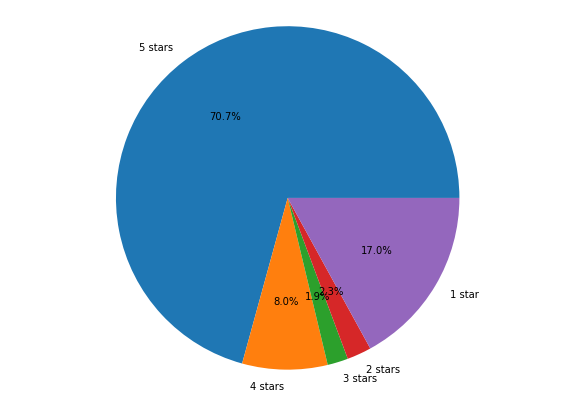

In [16]:
plt.figure(figsize =(10, 7)) 
plt.pie([33929, 3850, 932, 1101, 8161], labels = ['5 stars', '4 stars', '3 stars', '2 stars', '1 star'], autopct='%1.1f%%');
plt.axis('equal')
plt.show()

In [17]:
# Create smaller random samples from each rating to crate a balanced sample

sample_5 = analysis_df[analysis_df['stars']==5].sample(1000)
sample_4 = analysis_df[analysis_df['stars']==4].sample(1000)
sample_3 = analysis_df[analysis_df['stars']==3]
sample_2 = analysis_df[analysis_df['stars']==2].sample(1000)
sample_1 = analysis_df[analysis_df['stars']==1].sample(1000)


In [18]:
# Checking so that the samples are representative

In [19]:
analysis_df[analysis_df['stars']==5]['polarity_after_clean'].describe()

count    33929.000000
mean         0.371516
std          0.251206
min         -1.000000
25%          0.200000
50%          0.354167
75%          0.526667
max          1.000000
Name: polarity_after_clean, dtype: float64

In [20]:
sample_5['polarity_after_clean'].describe()

count    1000.000000
mean        0.366402
std         0.257450
min        -0.600000
25%         0.200000
50%         0.351111
75%         0.517500
max         1.000000
Name: polarity_after_clean, dtype: float64

We calculate the Z-statistic to check that the random samples are representative of the larger sample

H0: The random sample mean is the same as the mean of the full sample

HA: The means are not the same

If -1.98 < Z < 1.98 we do not reject the null hypothesis at 95% level of confidence and we can assume that the smaller samples are representative of the full sample.


In [21]:
n_5 = 1000
pop_mean_5 = 0.371516
sample_mean_5 = 0.374292
pop_std_5 = 0.251206

statistic_5 = (sample_mean_5 - pop_mean_5) / (pop_std_5 / math.sqrt(n_5))
print('The Z statistic is: ', statistic_5)

The Z statistic is:  0.34945354747209156


In [22]:
analysis_df[analysis_df['stars']==4]['polarity_after_clean'].describe()

count    3850.000000
mean        0.298890
std         0.226388
min        -1.000000
25%         0.160000
50%         0.300000
75%         0.438889
max         1.000000
Name: polarity_after_clean, dtype: float64

In [23]:
sample_4['polarity_after_clean'].describe()

count    1000.000000
mean        0.289029
std         0.225870
min        -0.750000
25%         0.153854
50%         0.290238
75%         0.421429
max         1.000000
Name: polarity_after_clean, dtype: float64

In [24]:
n_4 = 1000
pop_mean_4 = 0.298890
sample_mean_4 = 0.306799
pop_std_4 = 0.226388

statistic_4 = (sample_mean_4 - pop_mean_4) / (pop_std_4 / math.sqrt(n_4))
print('The Z statistic is: ', statistic_4)

The Z statistic is:  1.1047605886474419


In [25]:
analysis_df[analysis_df['stars']==2]['polarity_after_clean'].describe()

count    1101.000000
mean        0.013041
std         0.222674
min        -1.000000
25%        -0.090476
50%         0.000000
75%         0.125000
max         1.000000
Name: polarity_after_clean, dtype: float64

In [26]:
sample_2['polarity_after_clean'].describe()

count    1000.000000
mean        0.013278
std         0.220231
min        -1.000000
25%        -0.092857
50%         0.000000
75%         0.125000
max         1.000000
Name: polarity_after_clean, dtype: float64

In [27]:
n_2 = 1000
pop_mean_2 = 0.013041
sample_mean_2 = 0.017669
pop_std_2 = 0.222674

statistic_2 = (sample_mean_2 - pop_mean_2) / (pop_std_2 / math.sqrt(n_2))
print('The Z statistic is: ', statistic_2)

The Z statistic is:  0.6572397770399444


In [28]:
analysis_df[analysis_df['stars']==1]['polarity_after_clean'].describe()

count    8161.000000
mean       -0.107879
std         0.271774
min        -1.000000
25%        -0.233523
50%        -0.054630
75%         0.043290
max         1.000000
Name: polarity_after_clean, dtype: float64

In [29]:
sample_1['polarity_after_clean'].describe()

count    1000.000000
mean       -0.122669
std         0.291763
min        -1.000000
25%        -0.257396
50%        -0.051792
75%         0.035179
max         1.000000
Name: polarity_after_clean, dtype: float64

In [30]:
n_1 = 1000
pop_mean_1 = -0.107879
sample_mean_1 = -0.113292
pop_std_1 = 0.271774

statistic_1 = (sample_mean_1 - pop_mean_1) / (pop_std_1 / math.sqrt(n_1))
print('The Z statistic is: ', statistic_1)

The Z statistic is:  -0.6298398292144002


In [57]:
new_df = pd.concat([sample_5, sample_4, sample_3, sample_2, sample_1])

In [58]:
X = new_df['lemmatized']
y = new_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [59]:
X_train

1430     ['unclear', 'policy', 'poor', 'communication',...
4033     ['super', 'excite', 'super', 'excite', 'offer'...
8180     ['wait', 'refund', 'soon', 'get', 'wait', 'ref...
13955    ['poor', 'quality', 'clothing', 'poor', 'quali...
6729     ['first', 'time', 'use', 'first', 'time', 'use...
                               ...                        
15002    ['poor', 'quality', 'poor', 'quality', 'fabric...
10159    ['parcel', 'claim', 'deliver', 'parcel', 'clai...
5195     ['quick', 'response', 'great', 'kelly', 'provi...
19013    ['quality', 'item', 'poor', 'quality', 'item',...
2404     ['suite', 'suite', 'take', 'week', 'arrive', '...
Name: lemmatized, Length: 3945, dtype: object

In [60]:
X_test

5476    ['hoodie', 'take', 'day', 'come', 'hoodie', 't...
3334    ['coupon', 'issue', 'use', 'coupon', 'new', 'p...
2314    ['return', 'enquiry', 'covid', 'place', 'april...
1848    ['love', 'order', 'love', 'order', 'ive', 'com...
1827    ['update', 'address', 'submit', 'incorrect', '...
                              ...                        
6642    ['good', 'clothes', 'good', 'clothes', 'delive...
6616    ['first', 'first', 'get', 'jacket', 'im', 'sur...
5709    ['good', 'respond', 'good', 'respond', 'size',...
7887    ['still', 'wait', 'place', 'dec', 'inform', 's...
5489    ['hit', 'miss', 'hit', 'miss', 'thought', 'exp...
Name: lemmatized, Length: 987, dtype: object

In [61]:
y_train

1430     2
4033     1
8180     2
13955    2
6729     2
        ..
15002    1
10159    2
5195     4
19013    3
2404     3
Name: stars, Length: 3945, dtype: int64

In [62]:
y_test

5476    4
3334    3
2314    3
1848    3
1827    2
       ..
6642    2
6616    4
5709    3
7887    2
5489    3
Name: stars, Length: 987, dtype: int64

Modelling using balanced sample.

I create a model pipeline including the vectorizer, TfidfTransformer and classifier

# Naive Bayes (Multinomial)

In [63]:
model_nb = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                   ])

model_nb.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_nb.predict(X_test)

In [64]:
print('The model accuracy is %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

The model accuracy is 0.5238095238095238
              precision    recall  f1-score   support

           1       0.58      0.73      0.64       201
           2       0.44      0.44      0.44       202
           3       0.40      0.22      0.28       181
           4       0.51      0.45      0.48       196
           5       0.60      0.74      0.66       207

    accuracy                           0.52       987
   macro avg       0.50      0.52      0.50       987
weighted avg       0.51      0.52      0.51       987



In [65]:
print(confusion_matrix(ytest, pred_y))

[[147  38   8   0   8]
 [ 71  89  25   9   8]
 [ 30  56  39  39  17]
 [  4  15  18  88  71]
 [  3   5   7  38 154]]


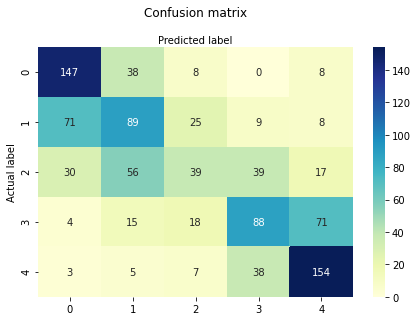

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
class_names = ['Not Recommended','Recommended'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

We will compare the results from the Multinomial Naive Bayes model with some other common models

# Logistic Regression

In [67]:
model_lr = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(class_weight='balanced')),
                   ])

model_lr.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [68]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.5440729483282675
              precision    recall  f1-score   support

           1       0.63      0.66      0.65       201
           2       0.46      0.42      0.44       202
           3       0.41      0.41      0.41       181
           4       0.55      0.48      0.52       196
           5       0.62      0.72      0.67       207

    accuracy                           0.54       987
   macro avg       0.54      0.54      0.54       987
weighted avg       0.54      0.54      0.54       987



In [69]:
print(confusion_matrix(ytest, pred_y))

[[132  41  17   1  10]
 [ 59  85  45   3  10]
 [ 15  45  75  34  12]
 [  1  12  30  95  58]
 [  1   3  14  39 150]]


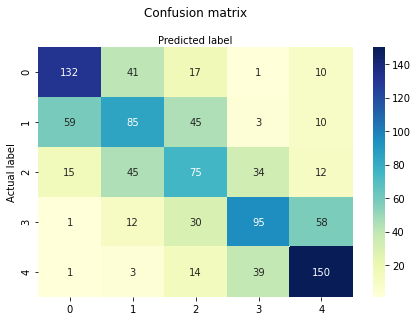

In [70]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
class_names = ['Not Recommended','Recommended'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Decision Tree

In [71]:
model_dt = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', DecisionTreeClassifier(class_weight='balanced')),
                   ])

model_dt.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_dt.predict(X_test)

In [72]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.39311043566362713
              precision    recall  f1-score   support

           1       0.47      0.47      0.47       201
           2       0.34      0.32      0.33       202
           3       0.28      0.24      0.26       181
           4       0.34      0.35      0.35       196
           5       0.49      0.56      0.52       207

    accuracy                           0.39       987
   macro avg       0.38      0.39      0.39       987
weighted avg       0.39      0.39      0.39       987



In [73]:
print(confusion_matrix(ytest, pred_y))

[[ 95  38  31  23  14]
 [ 62  64  40  21  15]
 [ 28  51  44  31  27]
 [  7  28  25  69  67]
 [  9  10  15  57 116]]


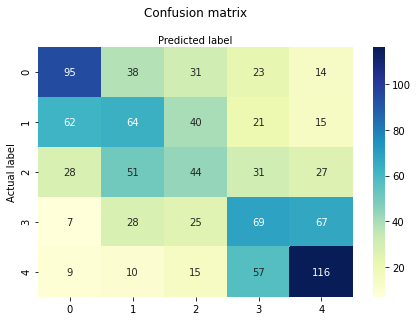

In [74]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
class_names = ['Not Recommended','Recommended'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Random Forest

In [75]:
model_rf = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(class_weight='balanced')),
                   ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_rf.predict(X_test)

In [76]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.49240121580547114
              precision    recall  f1-score   support

           1       0.52      0.66      0.58       201
           2       0.39      0.36      0.38       202
           3       0.37      0.21      0.27       181
           4       0.52      0.43      0.47       196
           5       0.56      0.76      0.65       207

    accuracy                           0.49       987
   macro avg       0.47      0.49      0.47       987
weighted avg       0.48      0.49      0.47       987



In [77]:
print(confusion_matrix(ytest, pred_y))

[[132  45   5   2  17]
 [ 81  73  31   9   8]
 [ 29  54  38  36  24]
 [  6  12  20  85  73]
 [  5   3   9  32 158]]


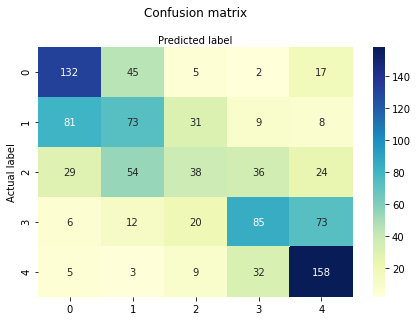

In [78]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
class_names = ['Not Recommended','Recommended'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Support Vector Machines (SVM)

In [79]:
model_svm = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', svm.SVC(class_weight='balanced')),
                   ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_svm.predict(X_test)

In [80]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.5329280648429585
              precision    recall  f1-score   support

           1       0.66      0.62      0.64       201
           2       0.48      0.49      0.48       202
           3       0.39      0.41      0.40       181
           4       0.52      0.43      0.47       196
           5       0.61      0.70      0.65       207

    accuracy                           0.53       987
   macro avg       0.53      0.53      0.53       987
weighted avg       0.53      0.53      0.53       987



In [81]:
print(confusion_matrix(ytest, pred_y))

[[124  45  24   0   8]
 [ 49  98  46   2   7]
 [ 13  46  75  36  11]
 [  1  13  32  84  66]
 [  1   3  17  41 145]]


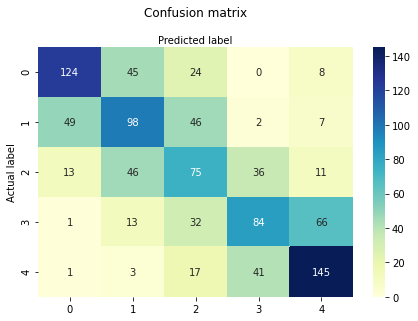

In [82]:
cnf_matrix = metrics.confusion_matrix(ytest, pred_y)
cnf_matrix
class_names = ['Not Recommended','Recommended'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "YlGnBu" ,fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

Modeling using the full sample - unbalanced.

In [ ]:
analysis_df['stars'].value_counts()

In [ ]:
X = analysis_df['lemmatized']
y = analysis_df['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
y_test

# Naive Bayes

In [ ]:
model_nb = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                   ])

model_nb.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_nb.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

# The model is only able to classify reviews that are rated 1 or 5 (the oversampled classes)

In [ ]:
print(confusion_matrix(ytest, pred_y))

# Logistic Regression

In [ ]:
model_lr = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression(class_weight = 'balanced')),     # The attributre class_weight='balanced' helps balance uneven sample classes
                   ])

model_lr.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

In [ ]:
print(confusion_matrix(ytest, pred_y))

# Decision Tree

In [ ]:
model_dt = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', DecisionTreeClassifier(class_weight='balanced')),
                   ])

model_dt.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_dt.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

In [ ]:
print(confusion_matrix(ytest, pred_y))

# Random Forest

In [ ]:
model_rf = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', RandomForestClassifier(class_weight='balanced')),
                   ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_rf.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

In [ ]:
print(confusion_matrix(ytest, pred_y))

# Support Vector Machines (SVM)

In [ ]:
model_svm = Pipeline([('vect', CountVectorizer(min_df = 5, ngram_range = (1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('clf', svm.SVC(class_weight = 'balanced')),
                   ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model_svm.predict(X_test)

In [ ]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

In [ ]:
print(confusion_matrix(ytest, pred_y))